# Preliminaries

In [1]:
#!pip -q uninstall -y ocropus4inf || true
#!pip -q install git+https://github.com/ocropus/ocropus4inf
#!pip -q install plotly

In [2]:
%matplotlib inline

In [3]:
import os

os.environ["WDS_CACHE"] = "/tmp/ocropus_cache"
os.makedirs(os.environ["WDS_CACHE"], exist_ok=True)




In [4]:
import torch
a = torch.zeros(3, device="cuda:0")
import os
from ipywidgets import interact_manual 
from IPython.display import clear_output
import webdataset as wds
from itertools import islice
import ocropus4inf.ocrinf as inf
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy.ndimage as ndi
#import display
from IPython.display import display
import traceback

In [5]:
def ensure_size(image, size=(3000, 3000)):
    if image.shape[0] > size[0] or image.shape[1] > size[1]:
        zoom = min(size[0] / image.shape[0], size[1] / image.shape[1])
        if image.ndim == 2:
            image = ndi.zoom(image, zoom, order=1)
        else:
            image = ndi.zoom(image, (zoom, zoom, 1), order=1)
    return image

In [6]:
collections = {
  "Internet Archive (A)": "https://storage.googleapis.com/ocro-iaa/segs/books-{volume:06d}-segs.tar",
  "Internet Archive (1)": "https://storage.googleapis.com/ocro-ia1/nlbin/ia1-{volume:06d}.tar",
  "Google 1000 Books": "https://storage.googleapis.com/ocro-g1000/tess/Volume_{volume:04d}.tgz",
}
collnames = list(collections.keys())
volumes = [f"{i:06d}" for i in range(0, 1000)]
all_pages = [i for i in range(100)]
fontsizes = [4, 6, 8, 10, 12, 14, 18, 24]
preproc_modes = ["none", "binarize", "threshold"]
debug_steps = ["none", "seg_probs", "wordmap"]
figure_sizes = ["8,8", "12,12", "16,16", "20,20", "24,24"]


In [7]:
textmodel = None # use default
segmodel = None # use default
pagerec = inf.PageRecognizer(textmodel=textmodel, segmodel=segmodel, device="?cuda:0")

loading model /home/tmb/.cache/ocropus4/seg_unet_v2-default.jit
loading model /home/tmb/.cache/ocropus4/lstm_resnet_v2-default.jit


# Running the OCR

In [8]:
@interact_manual(collection=collnames, volume=volumes, pageno=all_pages, fontsize=fontsizes, preproc=preproc_modes, step=debug_steps, figure_size=figure_sizes)
def process_page(collection, volume, pageno=25, fontsize=8, preproc="none", step="none", figure_size="12,12"):
  clear_output(wait=True)
  figure_size = tuple(int(x) for x in figure_size.split(","))
  url = collections[collection].format(volume=int(volume))
  if step == "none":
    fig, ax = plt.subplots(1, 1, figsize=figure_size)
  else:
    fig, axs = plt.subplots(1, 2, figsize=figure_size)
  ds = wds.WebDataset(url).decode("l").to_tuple("jpg;jpeg;png")
  gray = next(islice(ds, pageno, pageno+1))[0]
  gray = ensure_size(gray)
  start = time.time()
  results = pagerec.recognize(gray, preproc=preproc)
  if step == "none":
    ax.set_title(f"{volume} {pageno} ({time.time()-start:.1f}s) {url}")
    pagerec.draw_overlaid(fontsize=fontsize, ax=ax)
  else:
    axs[0].set_title(f"{volume} {pageno} ({time.time()-start:.1f}s) {url}")
    pagerec.draw_overlaid(fontsize=fontsize, ax=axs[0])
    if step == "seg_probs":
      axs[1].imshow(pagerec.seg_probs[:,:,1:])
    elif step == "wordmap":
      inf.show_seg(pagerec.wordmap, ax=axs[1])

interactive(children=(Dropdown(description='collection', options=('Internet Archive (A)', 'Internet Archive (1…

# Examples

/home/tmb/proj/ocropus4inf/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  return forward_call(*args, **kwargs)


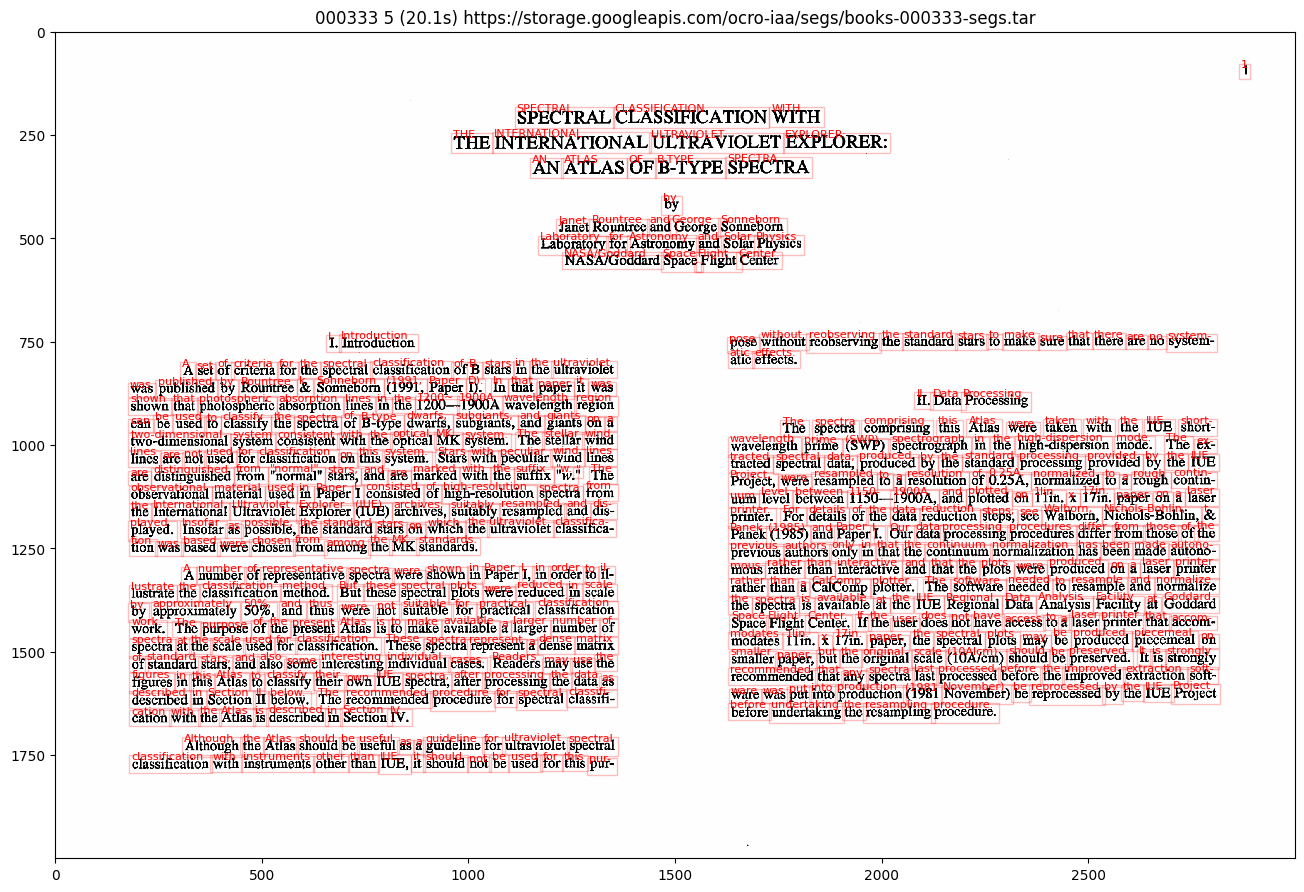

In [9]:
process_page("Internet Archive (A)", volume="000333", pageno=5, fontsize=8, preproc="none", figure_size="16,16")

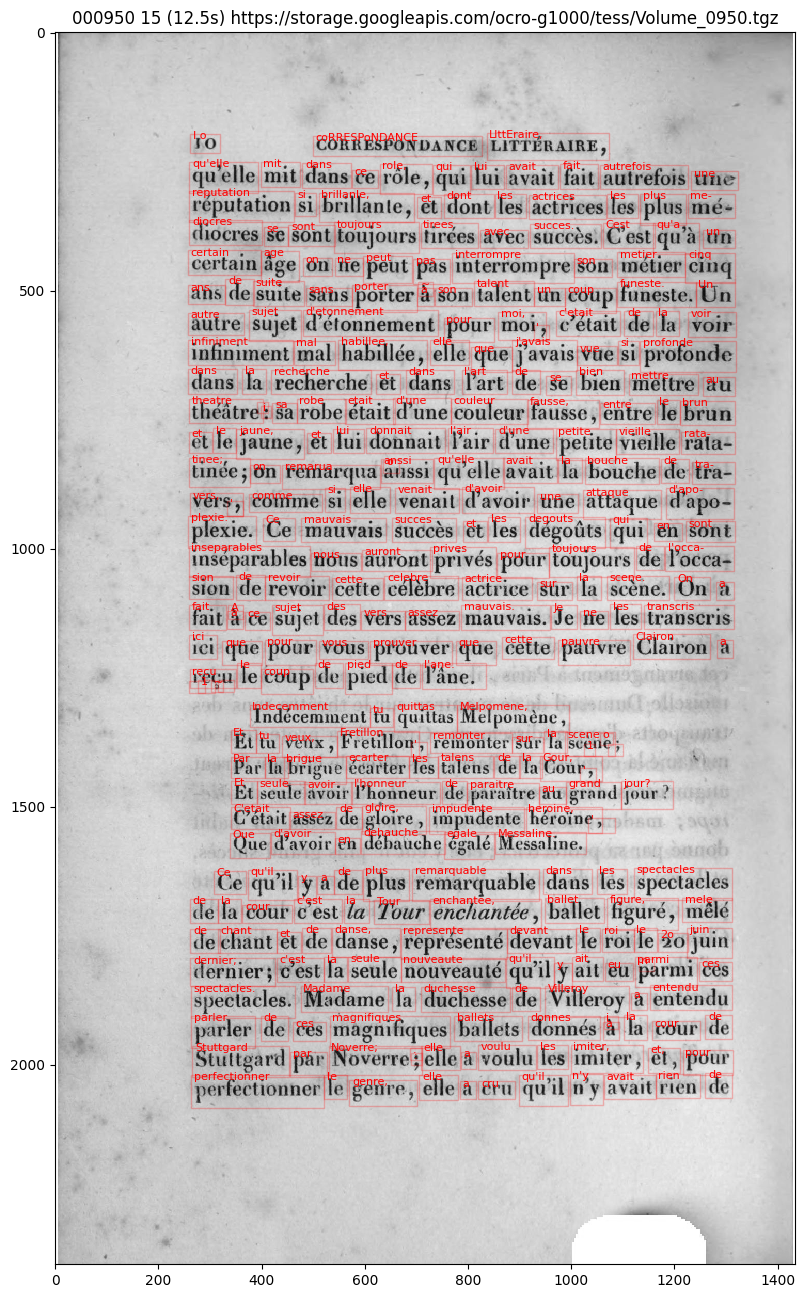

In [10]:
process_page("Google 1000 Books", volume="000950", pageno=15, fontsize=8, preproc="none", figure_size="16,16")

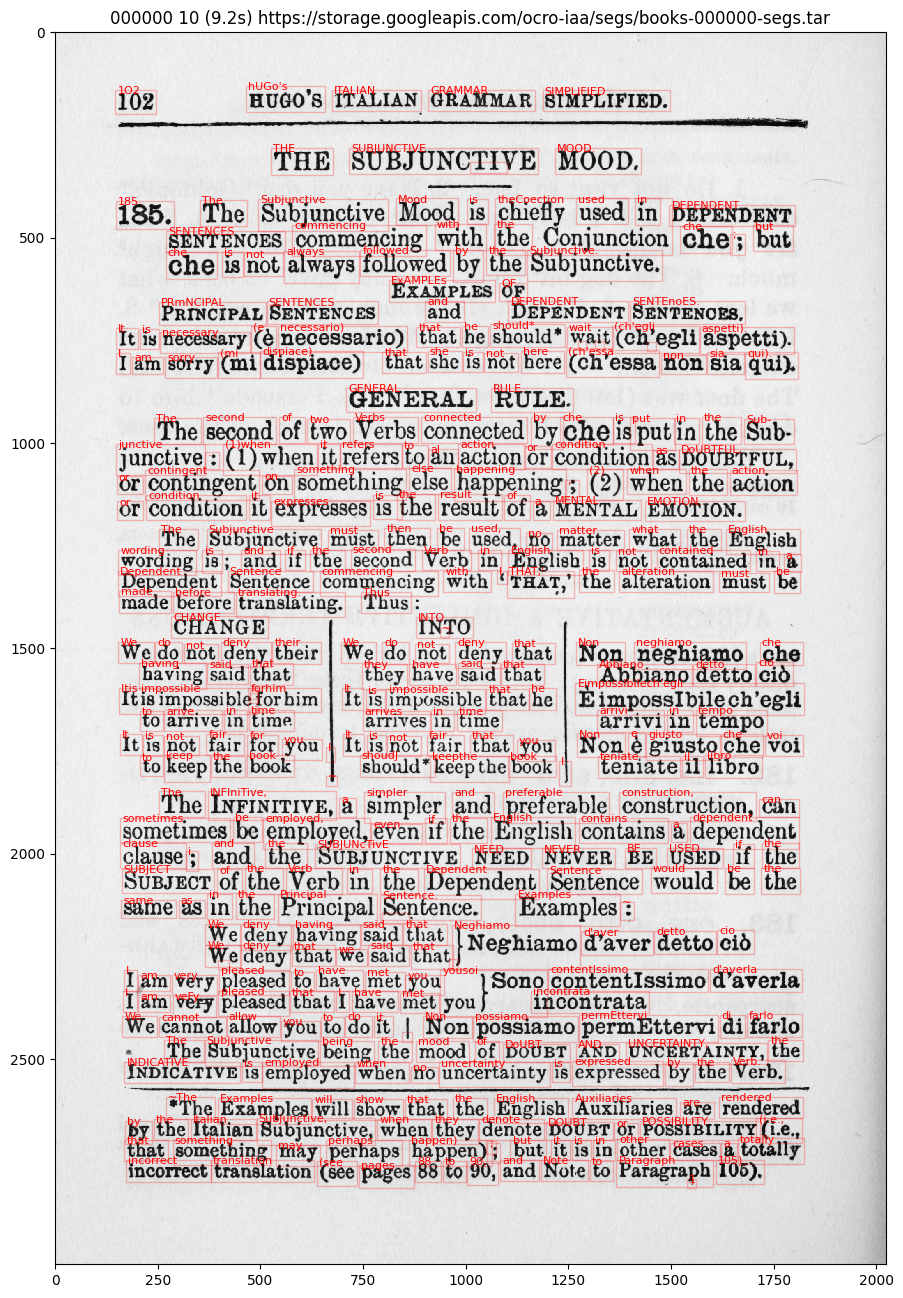

In [11]:
process_page("Internet Archive (A)", volume="000000", pageno=10, fontsize=8, preproc="none", figure_size="16,16")

# Pages that Need Fixing

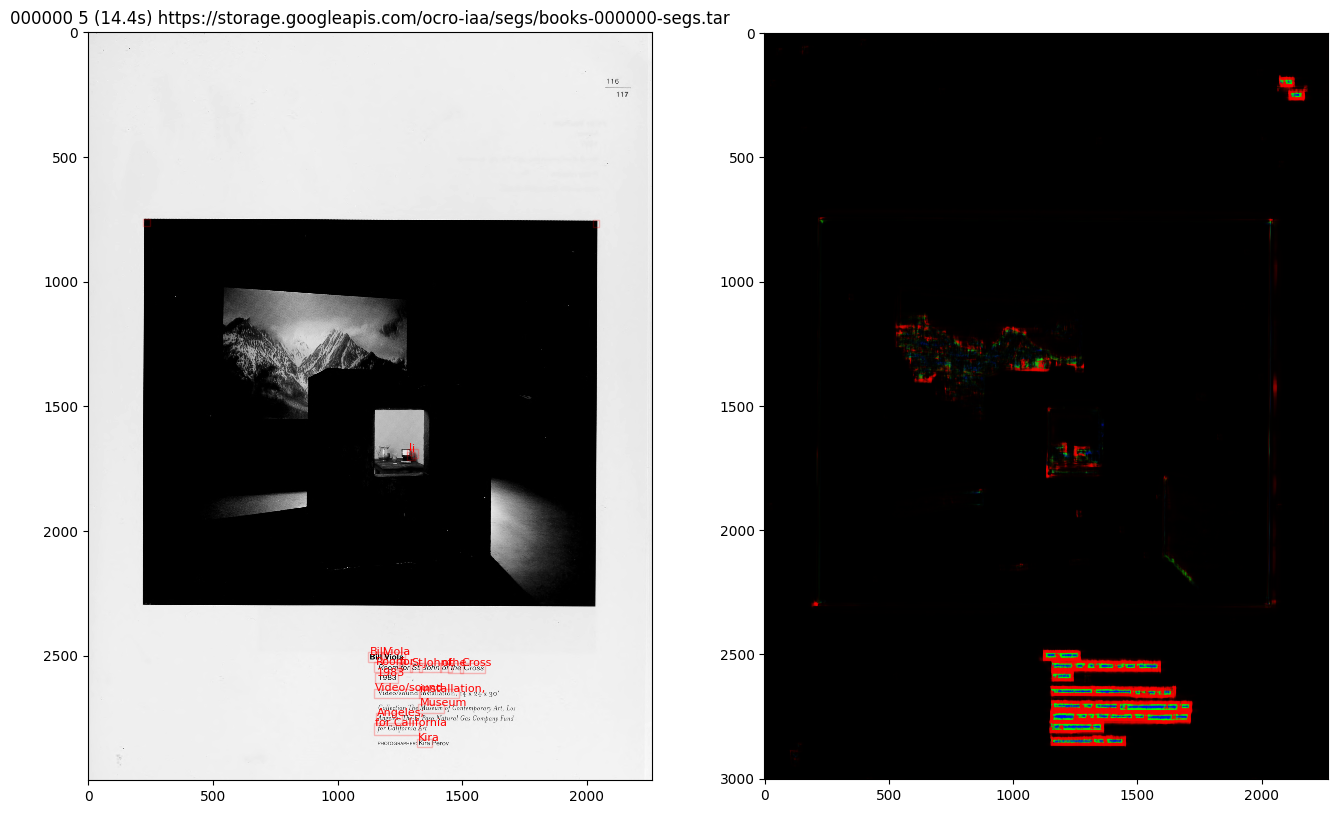

In [12]:
# for some reason, some of the bounding boxes are not picked up
# (this is unrelated to the presence of the image)
process_page("Internet Archive (A)", volume="000000", pageno=5, fontsize=8, preproc="none", step="seg_probs", figure_size="16,16")

Traceback (most recent call last):
  File "/tmp/ipykernel_44075/3797703388.py", line 14, in <module>
    process_page("Internet Archive (1)", volume="000020", pageno=15, fontsize=8, preproc="none", figure_size="8,8")
  File "/tmp/ipykernel_44075/1863922665.py", line 14, in process_page
    results = pagerec.recognize(gray, preproc=preproc)
  File "/home/tmb/proj/ocropus4inf/ocropus4inf/ocrinf.py", line 418, in recognize
    self.segmentation = compute_segmentation(self.seg_probs)
  File "/home/tmb/proj/ocropus4inf/ocropus4inf/ocrinf.py", line 289, in compute_segmentation
    if wordmap[comp] > 0:
IndexError: index 34666 is out of bounds for axis 0 with size 2591


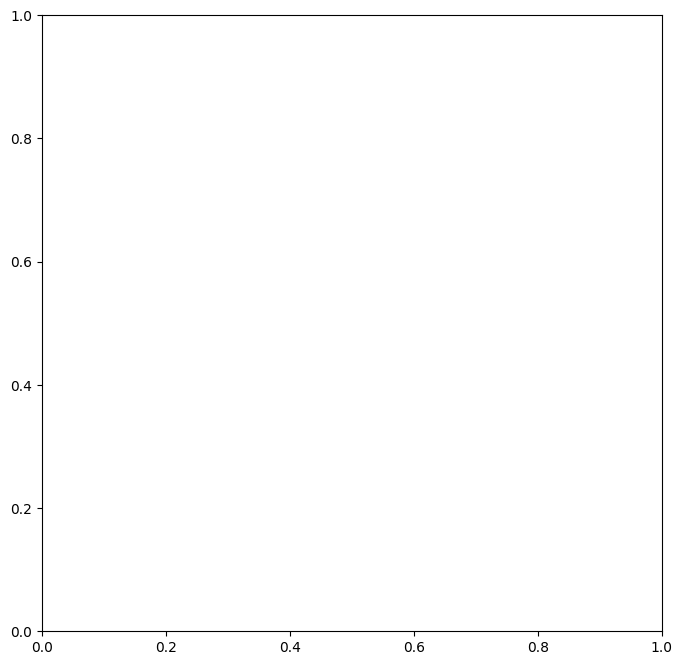

In [16]:
"""
File ~/proj/ocropus4inf/ocropus4inf/ocrinf.py:289, in compute_segmentation(probs, show)
    287 if word == 0:
    288     continue
--> 289 if wordmap[comp] > 0:
    290     # FIXME do something about ambiguous assignments
    291     # print(word, comp)
    292     pass
    293 wordmap[comp] = word

IndexError: index 34666 is out of bounds for axis 0 with size 2591
"""
try:
    process_page("Internet Archive (1)", volume="000020", pageno=15, fontsize=8, preproc="none", figure_size="8,8")
except IndexError as e:
    traceback.print_exc()